In [255]:
#STEP 1: Seeing if I can open this bad boy, simple test performed below with the all data dataFrame object, NYAllData
import pandas as pd

NYAllData = pd.read_csv('New_York_State_Statewide_COVID-19_Testing_20240306.csv')
NYAllData.loc[NYAllData['Geography Description'] == 'St. Lawrence', ['Geography Description']] = 'Saint Lawrence'

NYAllData

,Test Date,Geography Description,Geography Level,Total New Positives,Total Cases Per 100k,Total Cases Per 100k (7-day avg),New Positives PCR,Cases Per 100k PCR,New Positives Antigen,Cases Per 100k Antigen
0,03/03/2024,Albany,COUNTY,9,2.85,2.80,8,2.53,1,0.32
1,03/03/2024,Allegany,COUNTY,2,4.28,2.45,1,2.14,1,2.14
2,03/03/2024,Bronx,COUNTY,51,3.70,5.99,26,1.88,25,1.81
3,03/03/2024,Broome,COUNTY,3,1.52,3.19,3,1.52,0,0.00
4,03/03/2024,Cattaraugus,COUNTY,1,1.31,2.43,0,0.00,1,1.31
...,...,...,...,...,...,...,...,...,...,...
106867,03/01/2020,New York City,REGION,2,0.02,0.02,2,0.02,0,0.00
106868,03/01/2020,North Country,REGION,0,0.00,0.00,0,0.00,0,0.00
106869,03/01/2020,Southern Tier,REGION,0,0.00,0.00,0,0.00,0,0.00
106870,03/01/2020,Western New York,REGION,0,0.00,0.00,0,0.00,0,0.00


In [256]:
#Num rows = 72
#Getting all of the county names
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime

counties=[]
for i in range(0, 72):
    if NYAllData.at[i, 'Geography Level'] == 'COUNTY':
        counties.append(NYAllData.at[i, 'Geography Description'])
    



In [257]:
import geopandas as gpd

map_df = gpd.read_file("Counties_Shoreline.shp")

map_df

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((608219.061 4737612.320, 608193.470 4..."
1,Allegany,ALLE,974100,36003,020000,West,50470,49927,48946,46456,None,None,N,1035.209131,2019-04-26,210499.339692,2.681179e+09,"POLYGON ((250193.018 4712087.456, 250192.562 4..."
2,Bronx,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,None,None,Y,41.933548,2019-10-04,119895.489498,1.086074e+08,"MULTIPOLYGON (((593044.679 4516671.698, 593025..."
3,Broome,BROO,974102,36007,030000,Central,212160,200536,200600,198683,None,None,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((465447.405 4671514.322, 465436.926 4..."
4,Cattaraugus,CATT,974103,36009,040000,West,84234,83955,80317,77042,None,None,N,1324.309219,2019-04-26,276084.505177,3.429945e+09,"POLYGON ((215534.406 4715146.842, 215536.294 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Washington,WASH,974155,36115,530000,East,59330,61042,63216,61302,None,None,N,840.930564,2017-11-10,342601.088534,2.178000e+09,"MULTIPOLYGON (((629261.070 4824361.974, 629258..."
58,Wayne,WAYN,974156,36117,540000,Central,89123,93765,93772,91283,None,None,N,612.002795,2018-02-08,181763.235088,1.585080e+09,"POLYGON ((360415.647 4800420.303, 360417.878 4..."
59,Westchester,WEST,974157,36119,550000,East,874866,923459,949113,1004457,None,None,N,473.245006,2019-10-04,248650.567653,1.225699e+09,"MULTIPOLYGON (((603994.343 4525951.521, 604008..."
60,Wyoming,WYOM,974158,36121,560000,West,42507,43424,42155,40531,None,None,N,596.822633,2018-09-20,176096.925232,1.545764e+09,"POLYGON ((217004.051 4751905.154, 217012.462 4..."


MAE is:  17.333227817818628


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


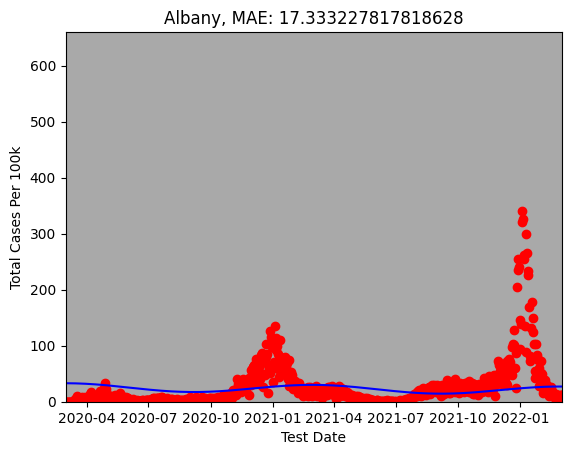

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  17.648986164347782


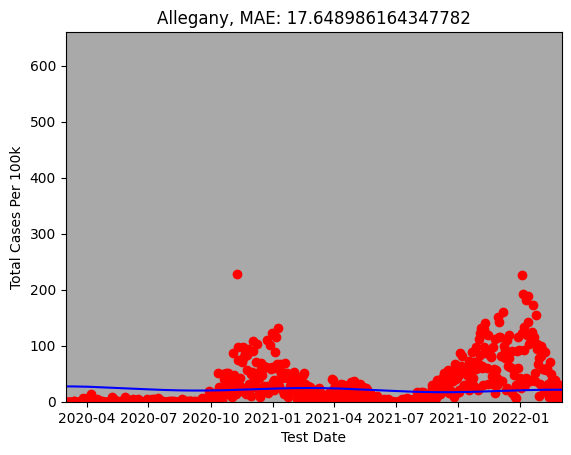

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  25.77101691282927


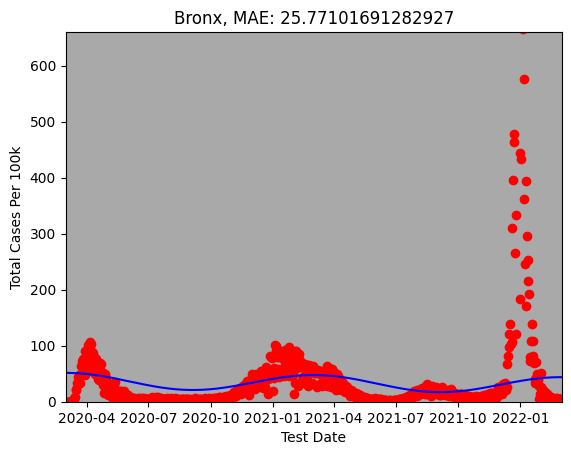

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  20.880171196416647


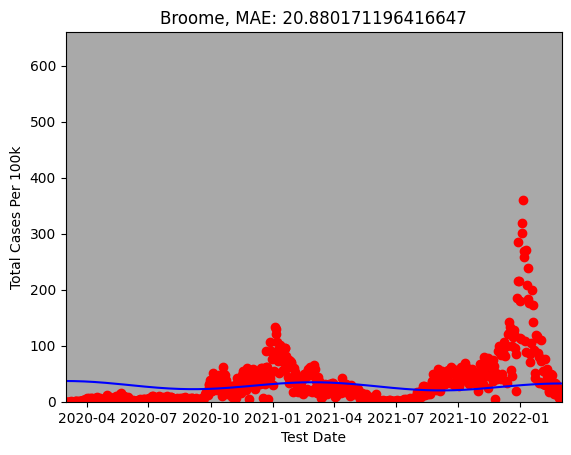

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  18.062839467537902


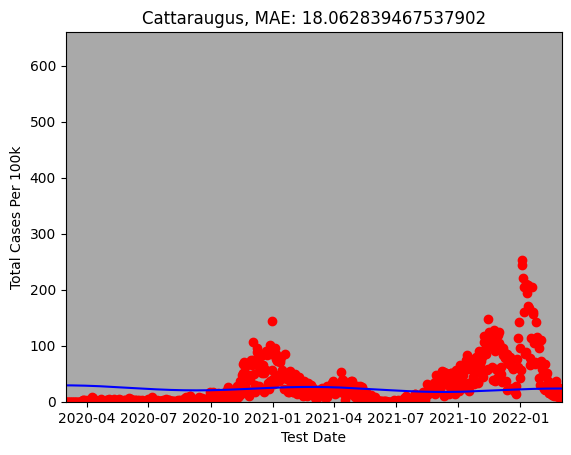

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.77722835625207


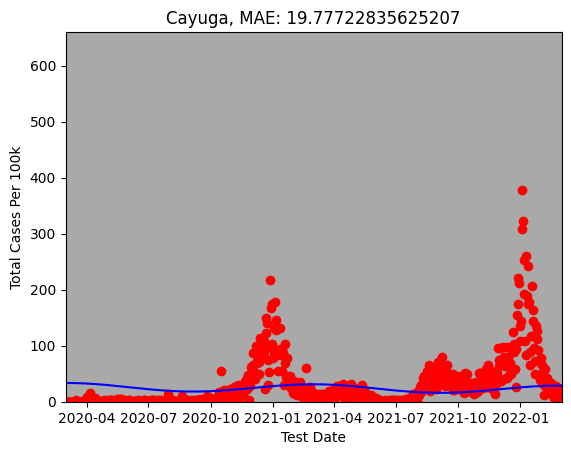

MAE is:  16.857361292770396


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


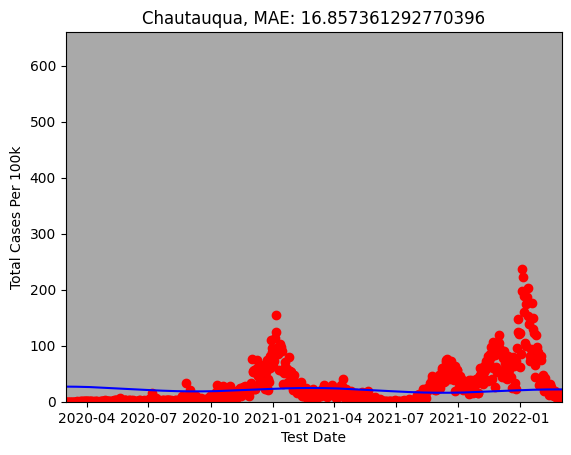

MAE is:  23.513167527047496


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


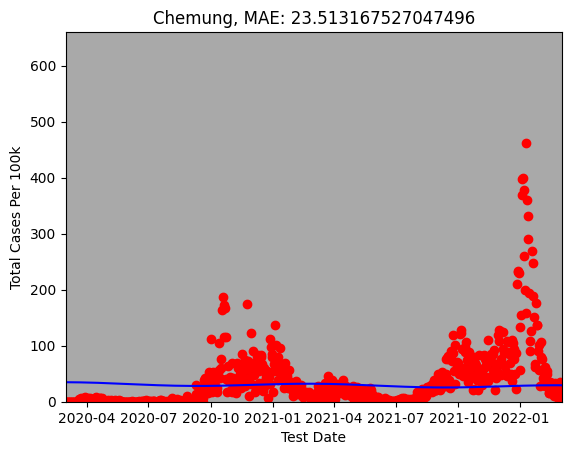

MAE is:  17.866473662369938


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


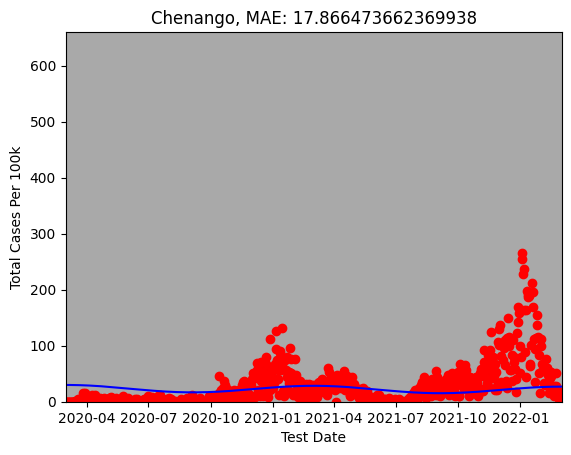

MAE is:  21.000110177778655


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


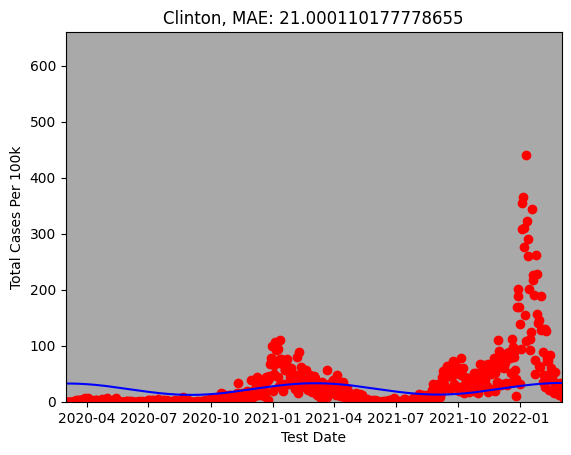

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.04126851035636


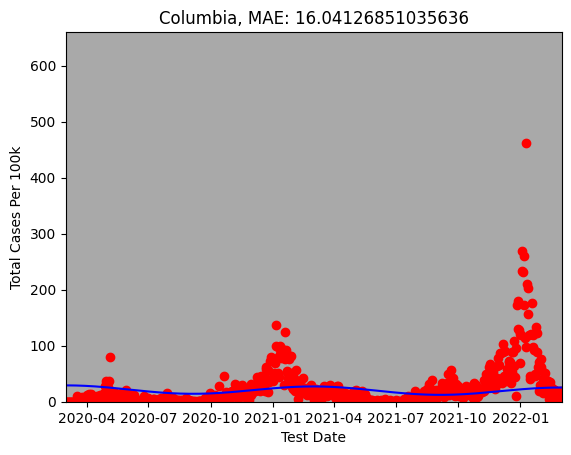

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  20.964412802720926


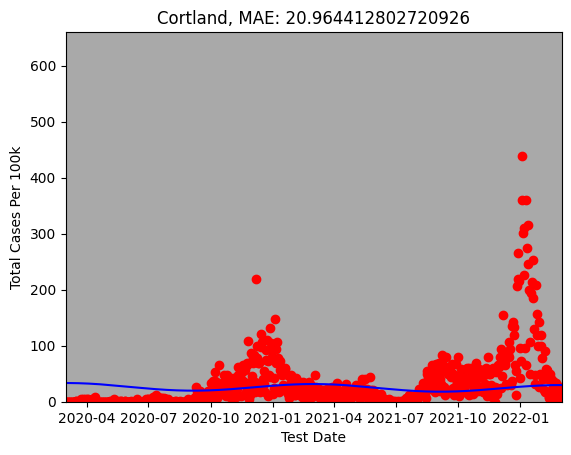

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.902826947811448


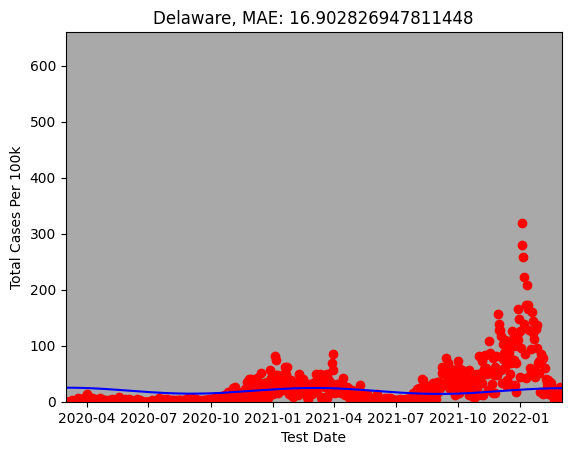

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.05059782155326


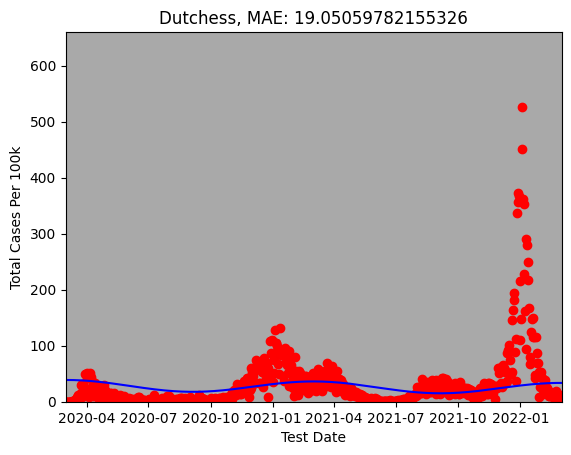

MAE is:  19.455061891066382


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


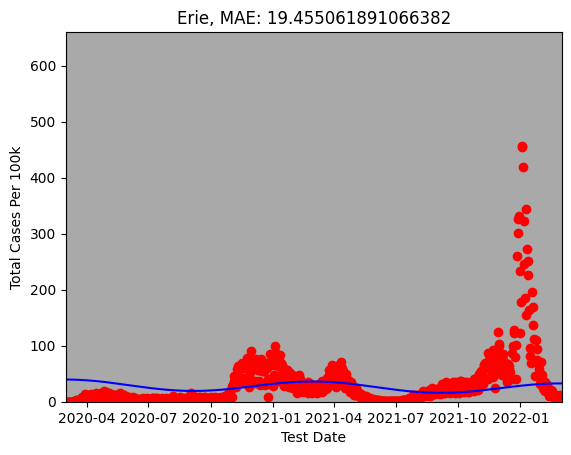

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  15.86271497362207


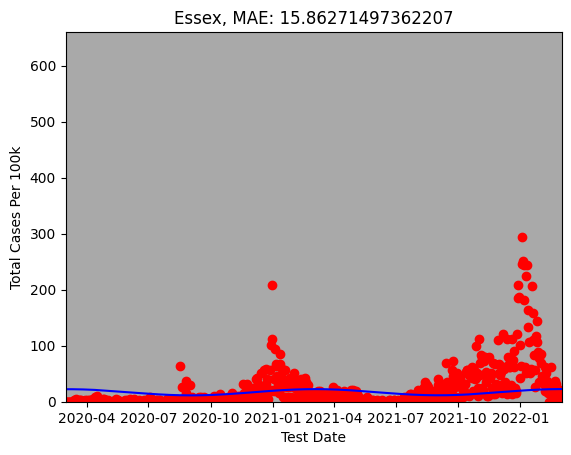

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  18.96568956102288


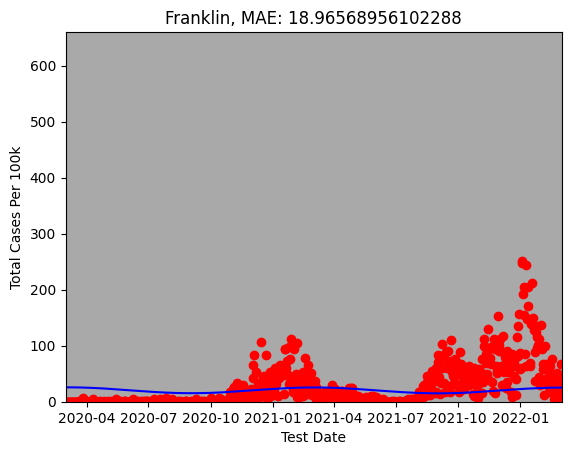

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  23.065489010803475


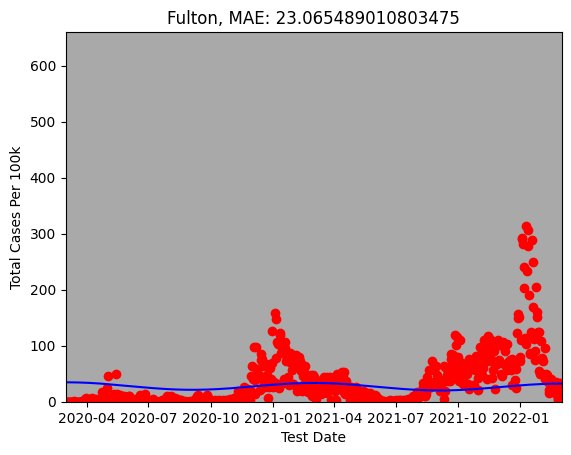

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.66112523696092


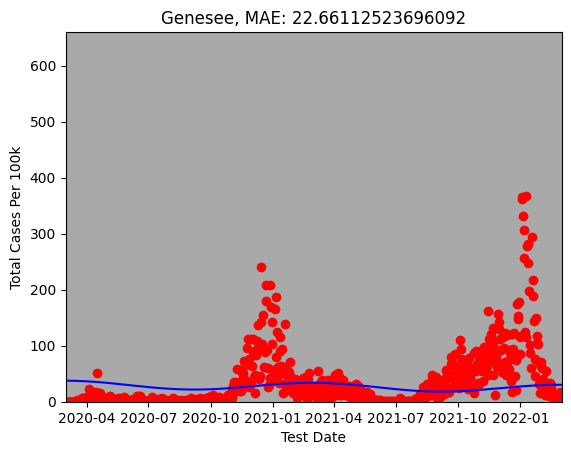

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.726798076454568


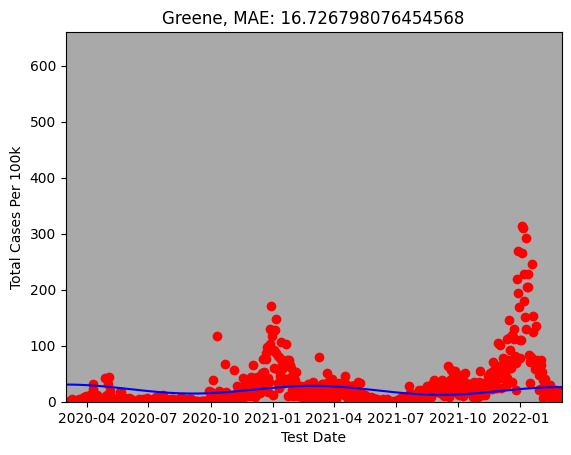

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  24.613068337599305


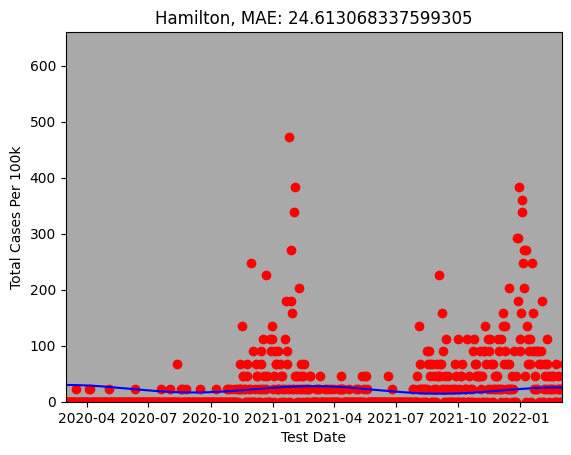

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.682318159793056


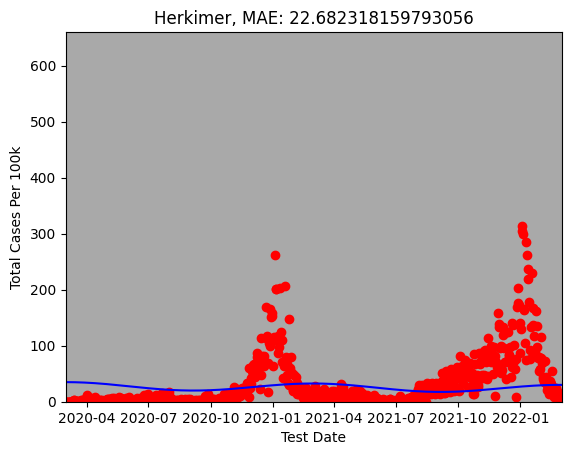

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  18.043704826431377


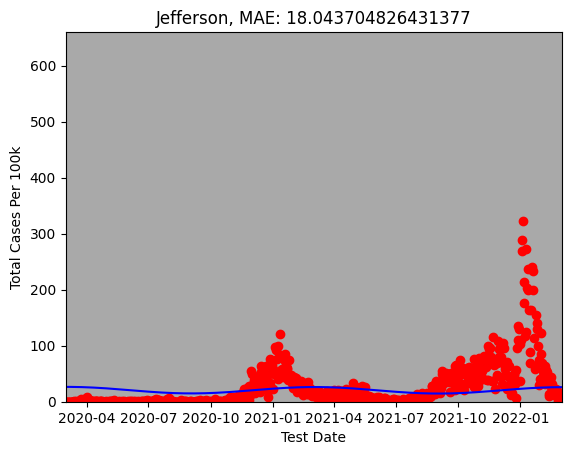

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  23.34246562881049


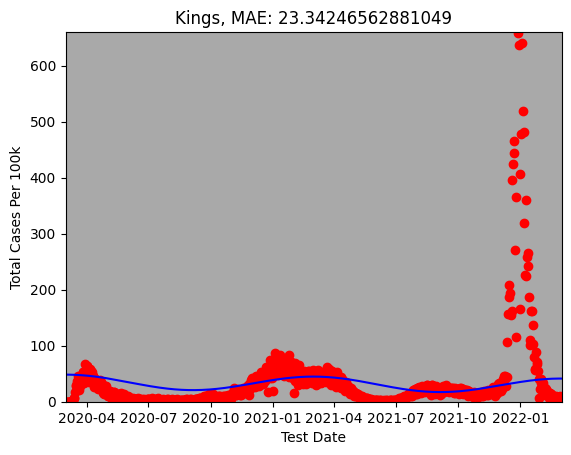

MAE is:  22.45568587959751


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


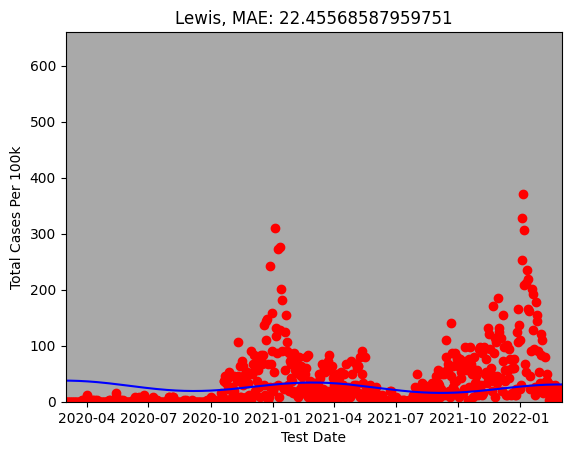

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.774525134220113


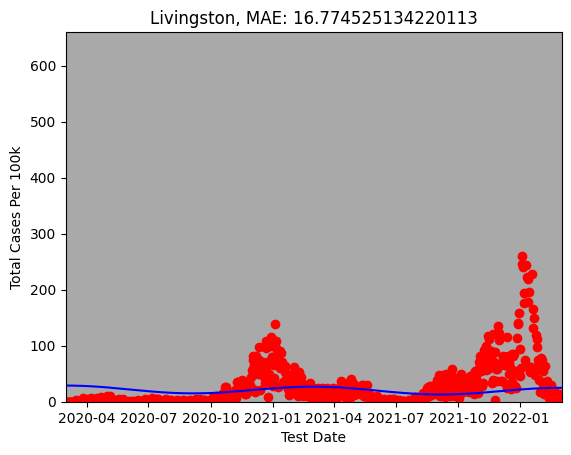

MAE is:  17.882022074208745


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


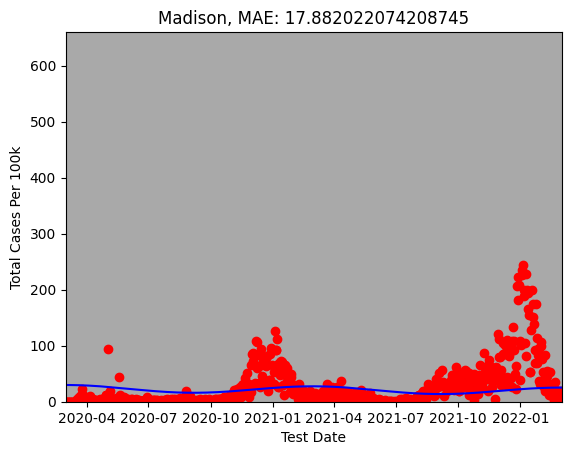

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.8832771600227


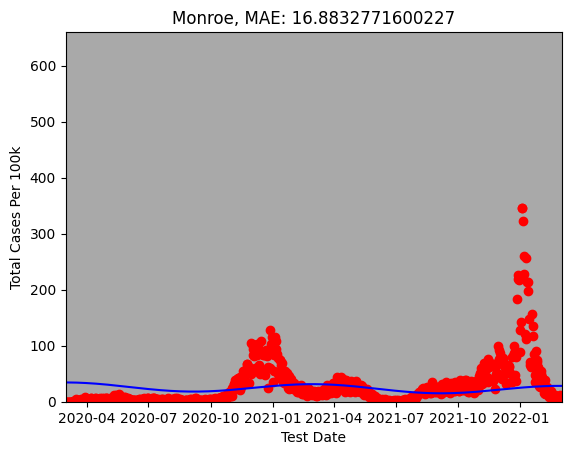

MAE is:  22.896281619952102


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


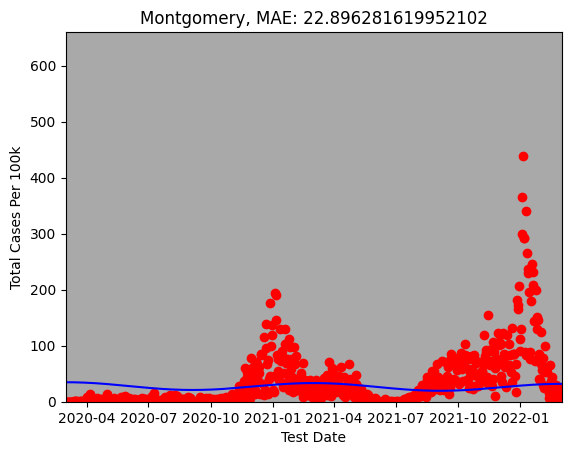

MAE is:  27.01499548876735


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


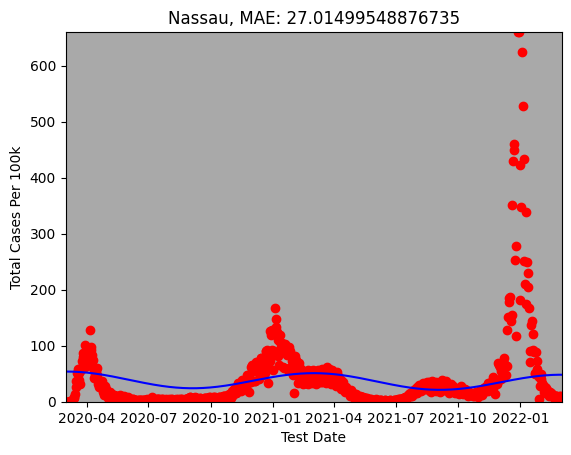

MAE is:  24.220546065652414


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


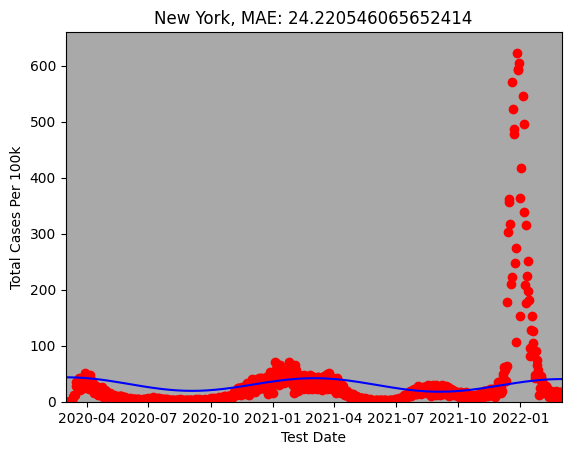

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  20.053046210160534


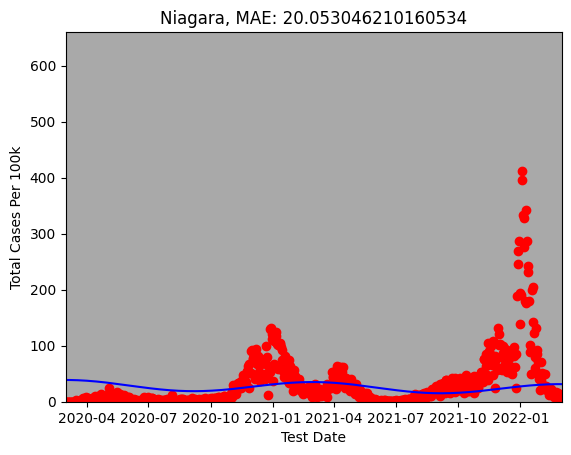

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.12814379039921


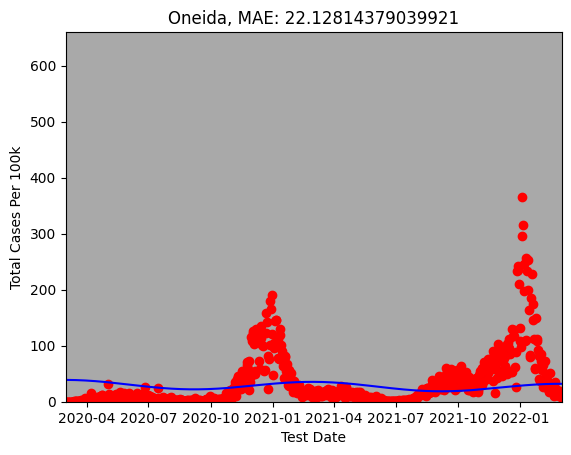

MAE is:  21.70077385622529


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


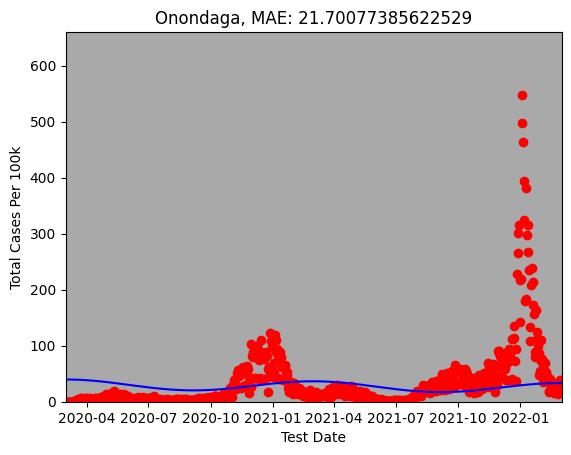

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  16.446782342509938


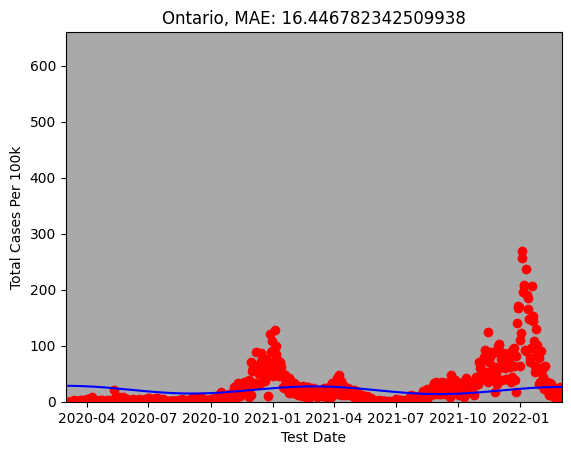

MAE is:  23.7547436693178


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


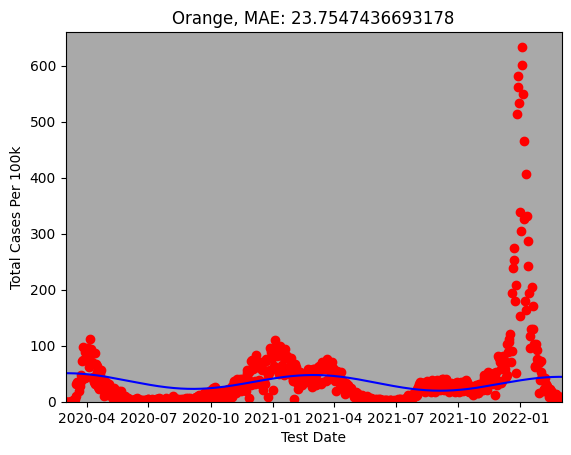

MAE is:  20.256944603266916


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


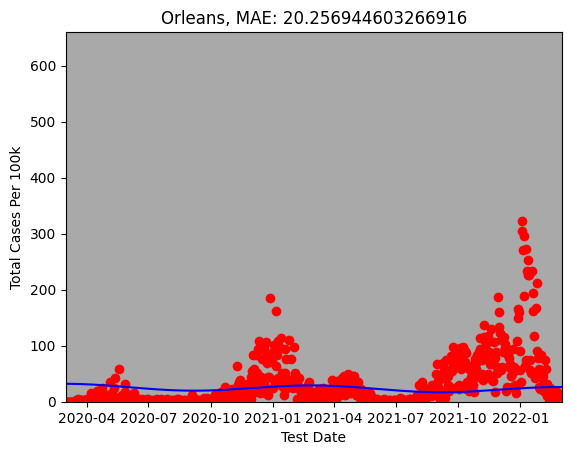

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  21.77972701476345


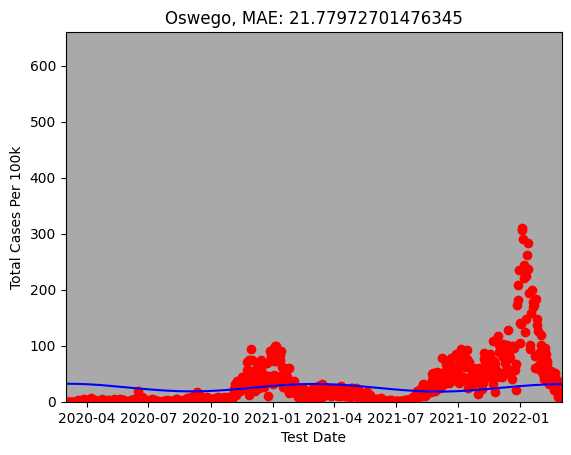

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  15.981710840685194


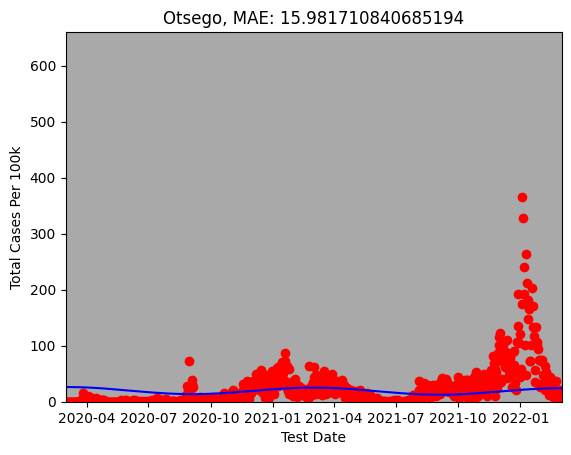

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.758249003026396


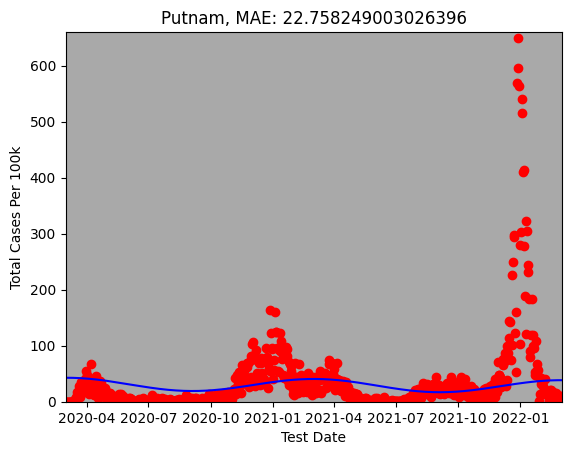

MAE is:  26.212578278393636


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


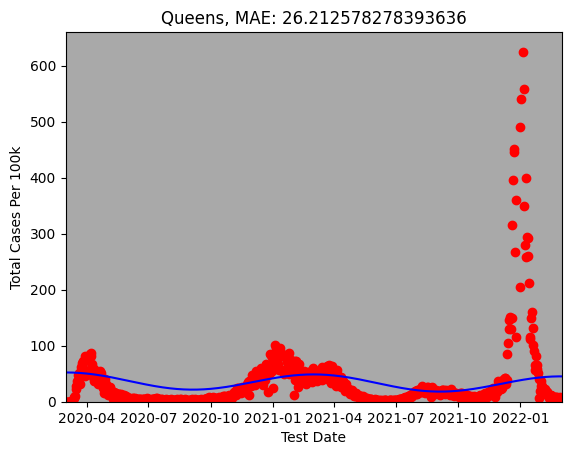

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  18.815691494886238


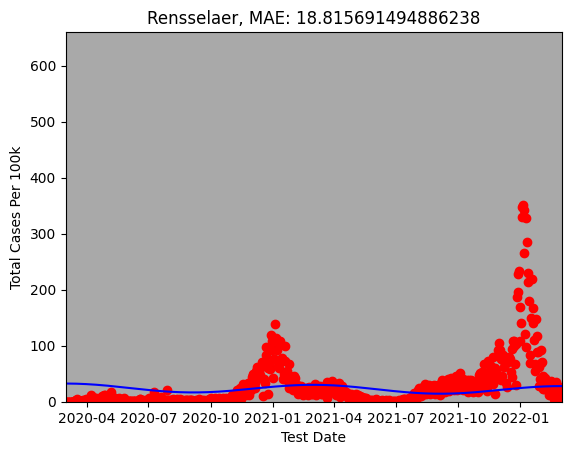

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  29.68655798997085


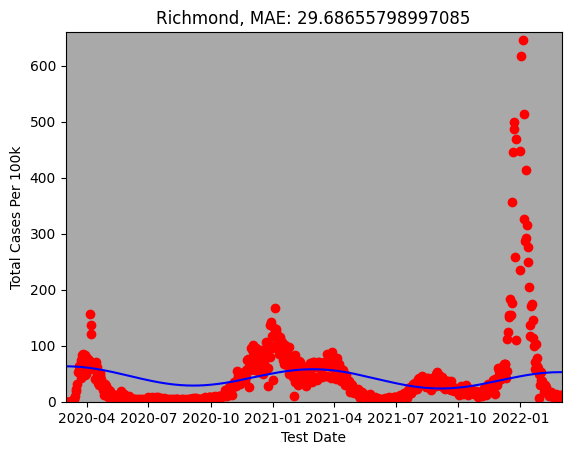

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  23.557034605143976


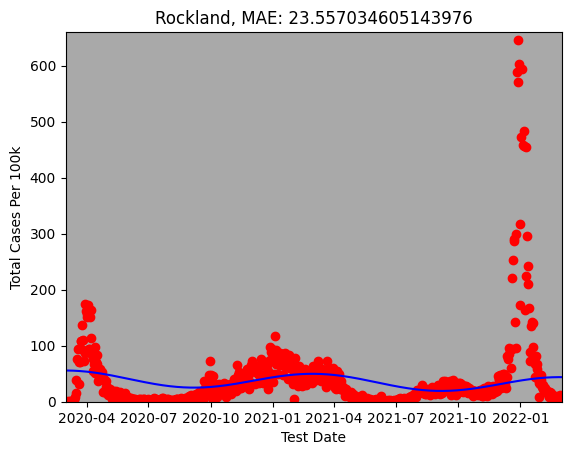

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.036098523809162


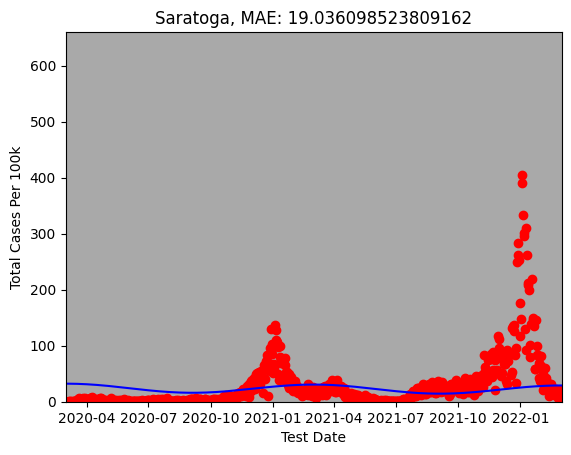

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.93825086104816


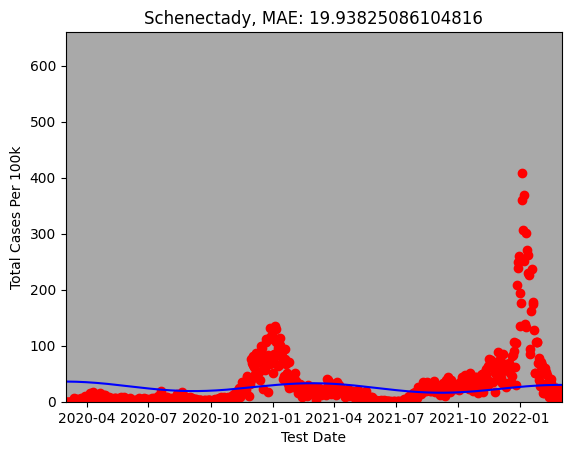

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  15.947013054439857


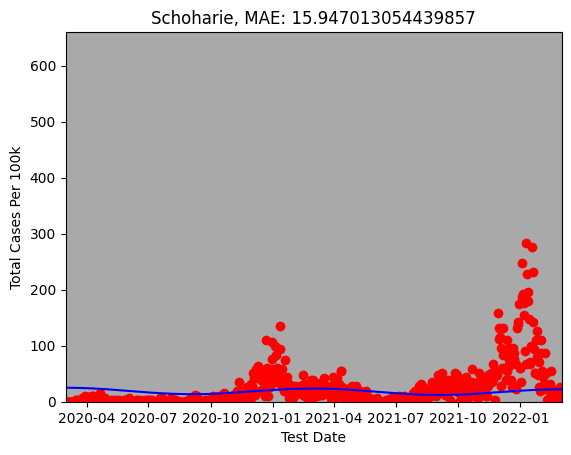

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.90225753039613


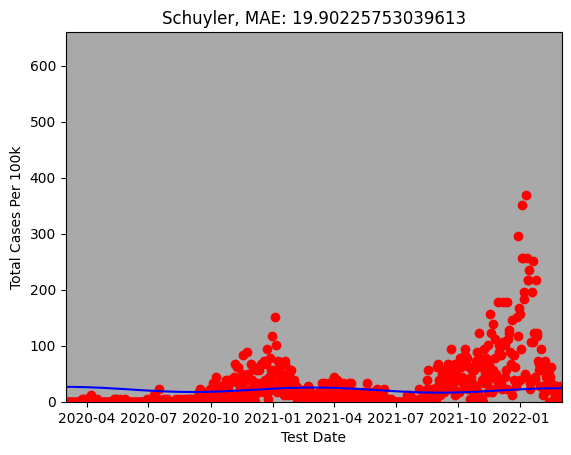

MAE is:  16.92810105280805


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


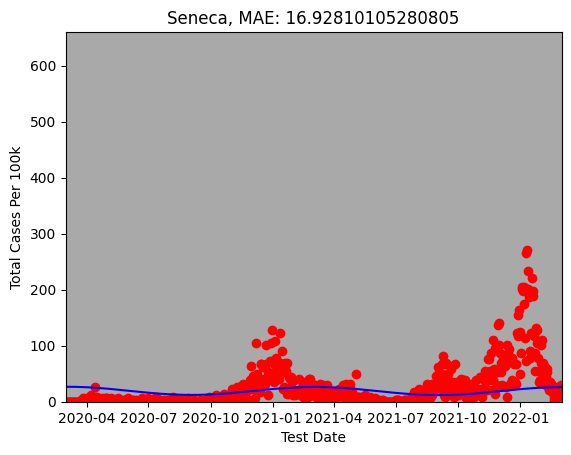

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  18.272945681738626


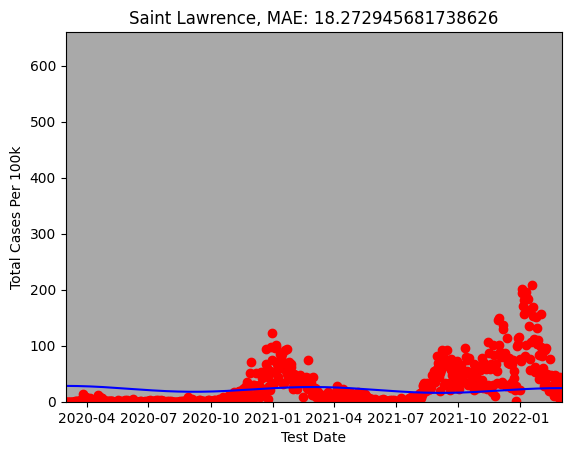

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.201295627853412


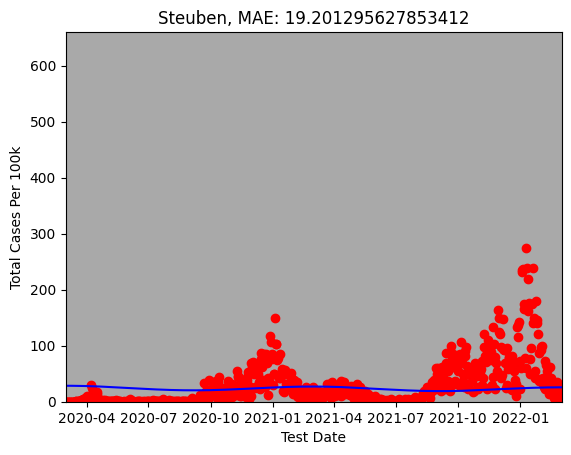

MAE is:  25.805584868276963


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


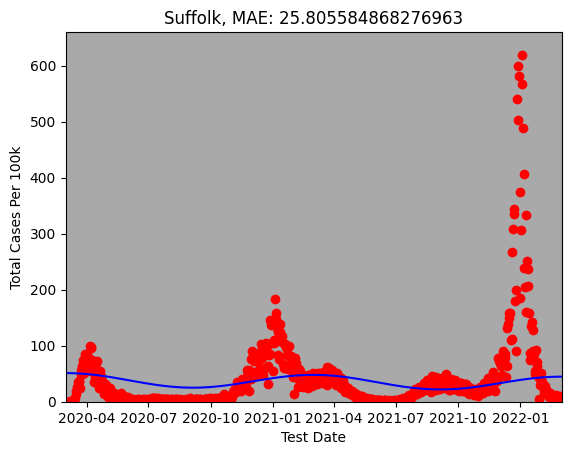

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.151334826585327


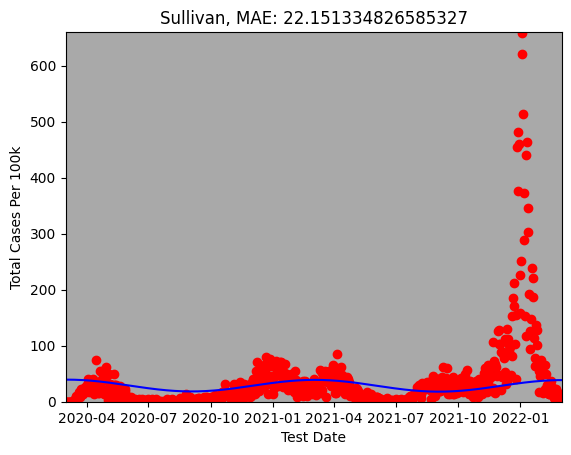

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  21.062766036452164


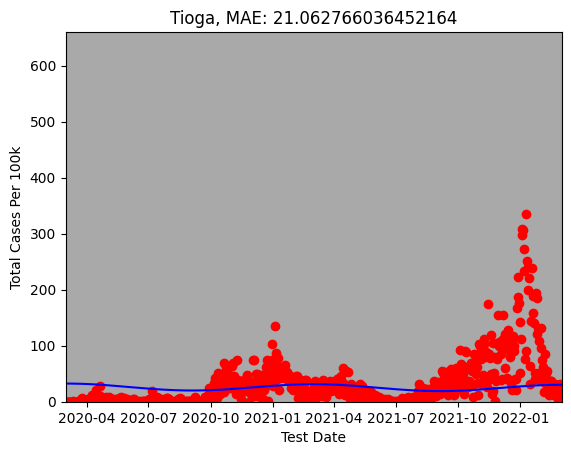

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.864774962540825


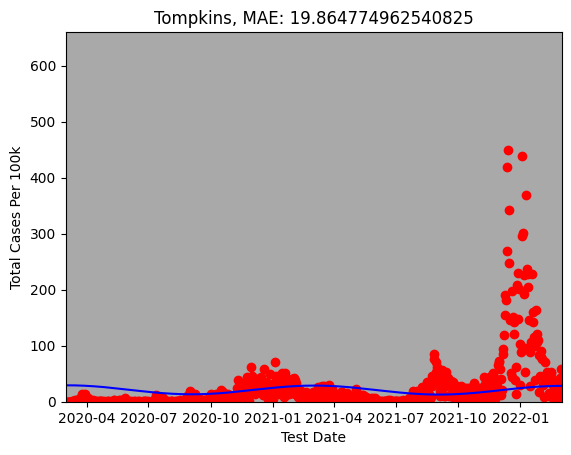

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  15.351589040718737


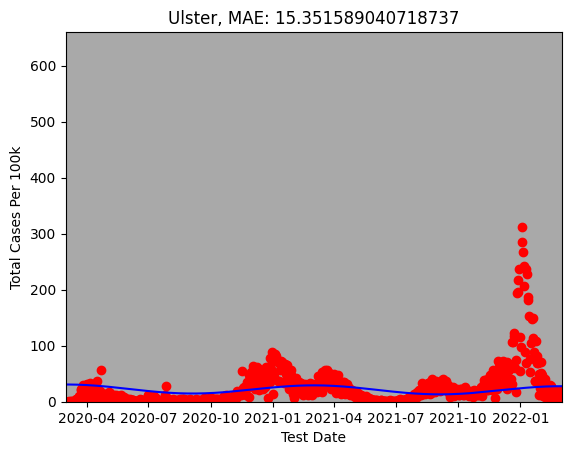

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  21.52789175823212


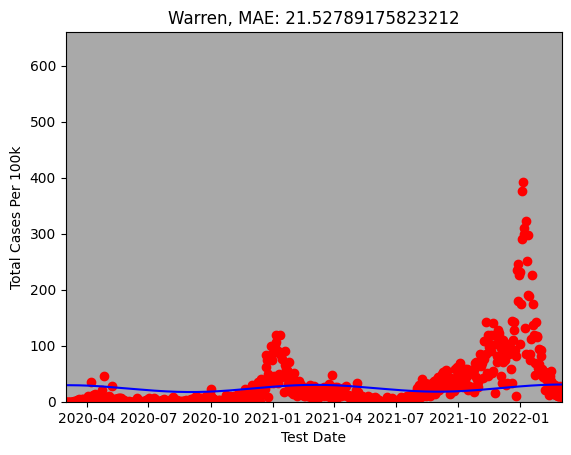

MAE is:  19.82215931581976


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


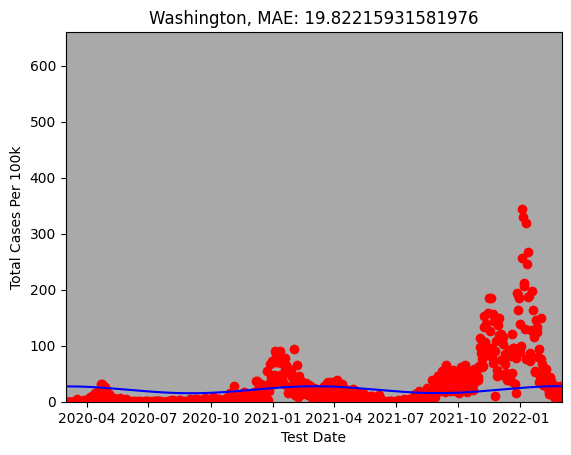

MAE is:  17.57874698614719


C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


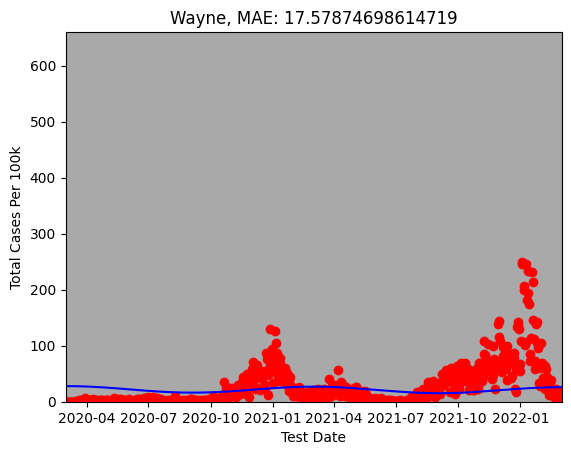

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  22.27137393958836


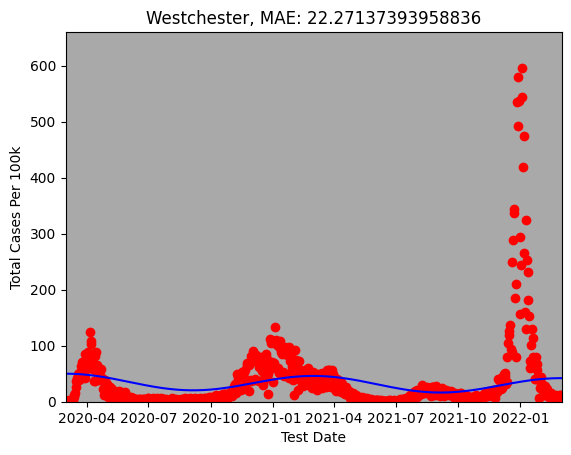

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  19.7420627494663


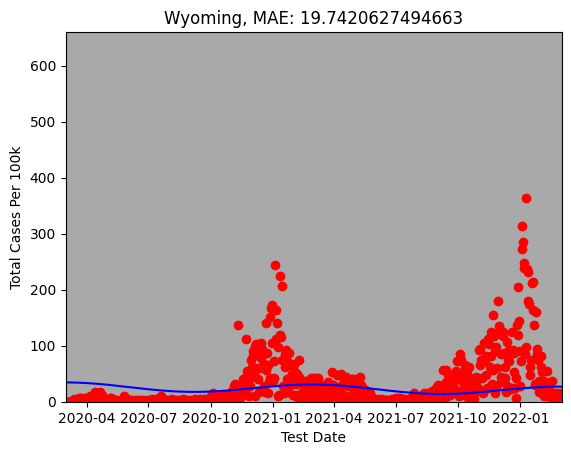

C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))
C:\Users\Tyler\AppData\Local\Temp\ipykernel_36640\1025662162.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)


MAE is:  14.629369065849582


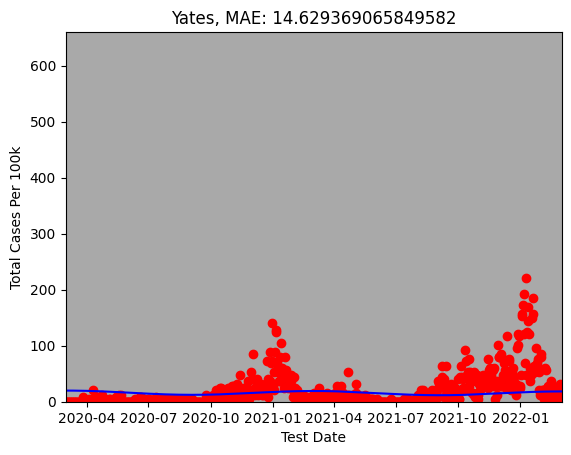

In [258]:
#iterating through each county to create a regression model and then plotting it 
NYAllData['Test Date +'] = pd.to_datetime(NYAllData['Test Date'])

for county in counties:
    SpecificCountyData = NYAllData.loc[NYAllData['Geography Description'] == county] 
    #Step 4: Building a model
    
    #doing something I read online to make this date time data actually usable
    #What is basically has done is make Test Date now be the number of days since the start going from 0 (days 1) to the end (the final recored day)
    #Very cheeky
    SpecificCountyData['Test Date +'] = np.arange(len(SpecificCountyData))


    #Adding a cosine feature
    SpecificCountyData['Cos'] = np.cos(2 * np.pi* SpecificCountyData['Test Date +'] / 365)

    X= SpecificCountyData[['Test Date +','Cos']]
    y = SpecificCountyData['Total Cases Per 100k']

    model = LinearRegression().fit(X,y)

    #adding the linear regression data for a county to the NYAllData dataFrame
    #Here is what happens, first a conditional runs to see if the matching county is found
    #then, once this occurs, the model adds a column called 'Linear Regression' to the NYAllData dataFrame
    #This column is then filled with the predicted values of the model
    NYAllData.loc[NYAllData['Geography Description'] == county, 'Linear Regression'] = model.predict(X) #CO-Pilot helped me with this line of code, I have no clue what is going on


    metrics.mean_absolute_error(model.predict(X), SpecificCountyData['Total Cases Per 100k'])
    print("MAE is: ", metrics.mean_absolute_error(model.predict(X), SpecificCountyData['Total Cases Per 100k']))


    x_axis= pd.to_datetime(SpecificCountyData['Test Date']) #This needed to be converted to a date time format to work, used CO-Pilot to help me with this
    y = SpecificCountyData['Total Cases Per 100k']

    ax = plt.axes()
    ax.set_facecolor("darkgrey")
    plt.xlim(datetime(2020,3,1), datetime(2022,3,3))
    plt.ylim(0, 660)
    plt.scatter(x_axis, y, color = 'red')

    plt.plot(x_axis, model.predict(X), color="blue") #CO-Pilot added the model.predict(X) part, and I think I understand what it is doing
    plt.xlabel("Test Date")
    plt.ylabel("Total Cases Per 100k")
    plt.title(county +", MAE: "+ str(metrics.mean_absolute_error(model.predict(X), SpecificCountyData['Total Cases Per 100k'])))
    plt.show()

In [259]:
NYAllData

,Test Date,Geography Description,Geography Level,Total New Positives,Total Cases Per 100k,Total Cases Per 100k (7-day avg),New Positives PCR,Cases Per 100k PCR,New Positives Antigen,Cases Per 100k Antigen,Test Date +,Linear Regression
0,03/03/2024,Albany,COUNTY,9,2.85,2.80,8,2.53,1,0.32,2024-03-03,21.280676
1,03/03/2024,Allegany,COUNTY,2,4.28,2.45,1,2.14,1,2.14,2024-03-03,15.499679
2,03/03/2024,Bronx,COUNTY,51,3.70,5.99,26,1.88,25,1.81,2024-03-03,36.217666
3,03/03/2024,Broome,COUNTY,3,1.52,3.19,3,1.52,0,0.00,2024-03-03,28.102199
4,03/03/2024,Cattaraugus,COUNTY,1,1.31,2.43,0,0.00,1,1.31,2024-03-03,17.892996
...,...,...,...,...,...,...,...,...,...,...,...,...
106867,03/01/2020,New York City,REGION,2,0.02,0.02,2,0.02,0,0.00,2020-03-01,NaN
106868,03/01/2020,North Country,REGION,0,0.00,0.00,0,0.00,0,0.00,2020-03-01,NaN
106869,03/01/2020,Southern Tier,REGION,0,0.00,0.00,0,0.00,0,0.00,2020-03-01,NaN
106870,03/01/2020,Western New York,REGION,0,0.00,0.00,0,0.00,0,0.00,2020-03-01,NaN


In [260]:
#plotting NY state
map_df

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((608219.061 4737612.320, 608193.470 4..."
1,Allegany,ALLE,974100,36003,020000,West,50470,49927,48946,46456,None,None,N,1035.209131,2019-04-26,210499.339692,2.681179e+09,"POLYGON ((250193.018 4712087.456, 250192.562 4..."
2,Bronx,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,None,None,Y,41.933548,2019-10-04,119895.489498,1.086074e+08,"MULTIPOLYGON (((593044.679 4516671.698, 593025..."
3,Broome,BROO,974102,36007,030000,Central,212160,200536,200600,198683,None,None,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((465447.405 4671514.322, 465436.926 4..."
4,Cattaraugus,CATT,974103,36009,040000,West,84234,83955,80317,77042,None,None,N,1324.309219,2019-04-26,276084.505177,3.429945e+09,"POLYGON ((215534.406 4715146.842, 215536.294 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Washington,WASH,974155,36115,530000,East,59330,61042,63216,61302,None,None,N,840.930564,2017-11-10,342601.088534,2.178000e+09,"MULTIPOLYGON (((629261.070 4824361.974, 629258..."
58,Wayne,WAYN,974156,36117,540000,Central,89123,93765,93772,91283,None,None,N,612.002795,2018-02-08,181763.235088,1.585080e+09,"POLYGON ((360415.647 4800420.303, 360417.878 4..."
59,Westchester,WEST,974157,36119,550000,East,874866,923459,949113,1004457,None,None,N,473.245006,2019-10-04,248650.567653,1.225699e+09,"MULTIPOLYGON (((603994.343 4525951.521, 604008..."
60,Wyoming,WYOM,974158,36121,560000,West,42507,43424,42155,40531,None,None,N,596.822633,2018-09-20,176096.925232,1.545764e+09,"POLYGON ((217004.051 4751905.154, 217012.462 4..."


In [261]:

mask = ((NYAllData['Test Date +'] == "2024-03-03") & (NYAllData['Geography Level'] == "COUNTY"))
OneDayData = NYAllData[mask]
OneDayData

,Test Date,Geography Description,Geography Level,Total New Positives,Total Cases Per 100k,Total Cases Per 100k (7-day avg),New Positives PCR,Cases Per 100k PCR,New Positives Antigen,Cases Per 100k Antigen,Test Date +,Linear Regression
0,03/03/2024,Albany,COUNTY,9,2.85,2.80,8,2.53,1,0.32,2024-03-03,21.280676
1,03/03/2024,Allegany,COUNTY,2,4.28,2.45,1,2.14,1,2.14,2024-03-03,15.499679
2,03/03/2024,Bronx,COUNTY,51,3.70,5.99,26,1.88,25,1.81,2024-03-03,36.217666
3,03/03/2024,Broome,COUNTY,3,1.52,3.19,3,1.52,0,0.00,2024-03-03,28.102199
4,03/03/2024,Cattaraugus,COUNTY,1,1.31,2.43,0,0.00,1,1.31,2024-03-03,17.892996
...,...,...,...,...,...,...,...,...,...,...,...,...
57,03/03/2024,Washington,COUNTY,2,3.29,4.70,1,1.64,1,1.64,2024-03-03,28.378866
58,03/03/2024,Wayne,COUNTY,1,1.10,5.17,1,1.10,0,0.00,2024-03-03,24.023592
59,03/03/2024,Westchester,COUNTY,41,4.14,7.75,22,2.22,19,1.92,2024-03-03,34.166797
60,03/03/2024,Wyoming,COUNTY,1,2.52,4.68,1,2.52,0,0.00,2024-03-03,19.436627


In [262]:
extracted_cols = OneDayData[["Geography Description",'Total Cases Per 100k', 'Linear Regression', 'Test Date +']]
result_df = pd.concat([map_df, extracted_cols], axis=1)

In [263]:
result_df

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,...,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry,Geography Description,Total Cases Per 100k,Linear Regression,Test Date +
0,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,...,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((608219.061 4737612.320, 608193.470 4...",Albany,2.85,21.280676,2024-03-03
1,Allegany,ALLE,974100,36003,020000,West,50470,49927,48946,46456,...,N,1035.209131,2019-04-26,210499.339692,2.681179e+09,"POLYGON ((250193.018 4712087.456, 250192.562 4...",Allegany,4.28,15.499679,2024-03-03
2,Bronx,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,...,Y,41.933548,2019-10-04,119895.489498,1.086074e+08,"MULTIPOLYGON (((593044.679 4516671.698, 593025...",Bronx,3.70,36.217666,2024-03-03
3,Broome,BROO,974102,36007,030000,Central,212160,200536,200600,198683,...,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((465447.405 4671514.322, 465436.926 4...",Broome,1.52,28.102199,2024-03-03
4,Cattaraugus,CATT,974103,36009,040000,West,84234,83955,80317,77042,...,N,1324.309219,2019-04-26,276084.505177,3.429945e+09,"POLYGON ((215534.406 4715146.842, 215536.294 4...",Cattaraugus,1.31,17.892996,2024-03-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Washington,WASH,974155,36115,530000,East,59330,61042,63216,61302,...,N,840.930564,2017-11-10,342601.088534,2.178000e+09,"MULTIPOLYGON (((629261.070 4824361.974, 629258...",Washington,3.29,28.378866,2024-03-03
58,Wayne,WAYN,974156,36117,540000,Central,89123,93765,93772,91283,...,N,612.002795,2018-02-08,181763.235088,1.585080e+09,"POLYGON ((360415.647 4800420.303, 360417.878 4...",Wayne,1.10,24.023592,2024-03-03
59,Westchester,WEST,974157,36119,550000,East,874866,923459,949113,1004457,...,N,473.245006,2019-10-04,248650.567653,1.225699e+09,"MULTIPOLYGON (((603994.343 4525951.521, 604008...",Westchester,4.14,34.166797,2024-03-03
60,Wyoming,WYOM,974158,36121,560000,West,42507,43424,42155,40531,...,N,596.822633,2018-09-20,176096.925232,1.545764e+09,"POLYGON ((217004.051 4751905.154, 217012.462 4...",Wyoming,2.52,19.436627,2024-03-03


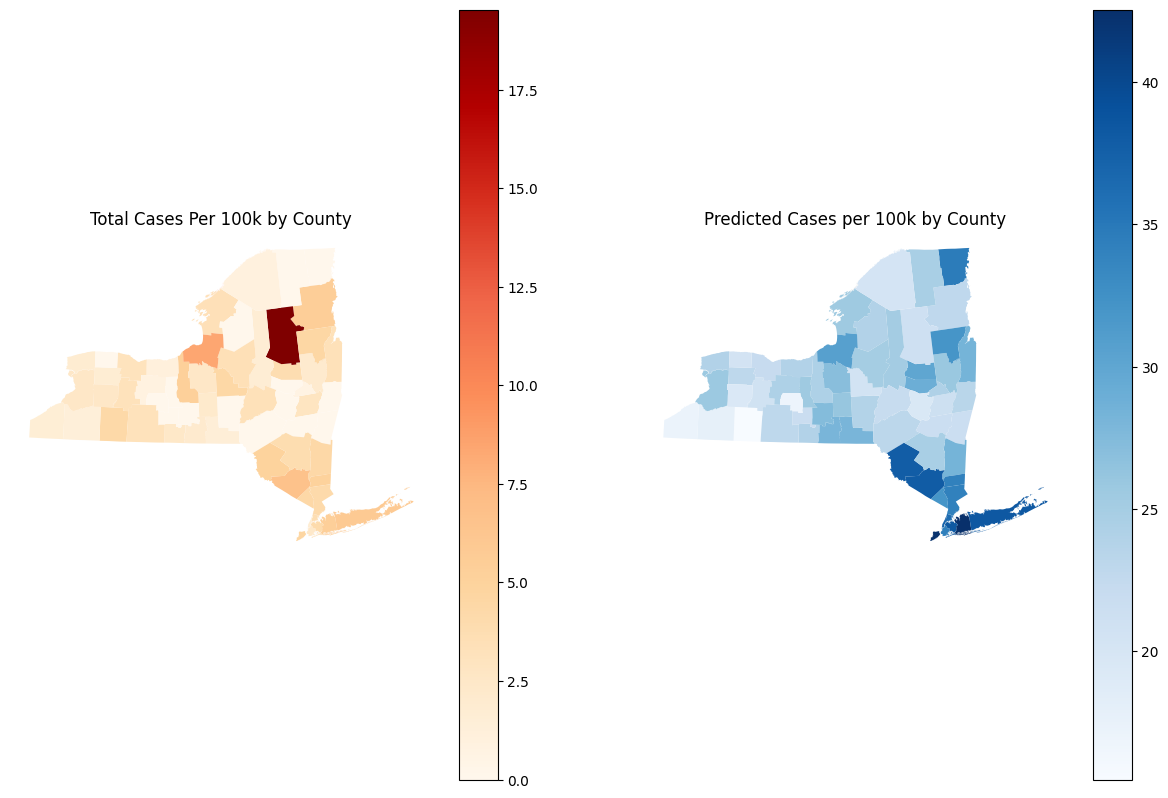

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# First map: Total Cases Per 100k
result_df.plot(column='Total Cases Per 100k', cmap='OrRd', legend=True, ax=ax1)
ax1.set_title("Total Cases Per 100k by County")
ax1.set_axis_off()


# Second map: Linear Regression
result_df.plot(column='Linear Regression', cmap='Blues', legend=True, ax=ax2)
ax2.set_title("Predicted Cases per 100k by County")
ax2.set_axis_off()

plt.show()